In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
import pytorch_lightning as pl
import numpy as np
from matplotlib import pyplot as plt, gridspec
from celluloid import Camera
from IPython.display import display, HTML
from tqdm.notebook import tqdm, trange
import seaborn as sns
from torchvision.datasets import MNIST, CIFAR10
from torchvision.models import resnet50
import warnings
from IPython.display import clear_output
from collections import defaultdict
import time
import logging
import random

%matplotlib inline
sns.set_theme(style="whitegrid")

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
# torch.use_deterministic_algorithms(True);

Напишем наш метод, наследуясь от torch.optim.Optimizer

In [2]:
class MyOptimizer1(torch.optim.Optimizer): 
      
    # Init Method: 
    def __init__(self, params, lr=1e-2): 
        super(MyOptimizer1, self).__init__(params, defaults={})
        self.lr = lr # Used for initialization of parameter L
      
    # Step Method 
    def step(self): 
        for group in self.param_groups: 
            for p in group['params']: 
                if p.grad is None: 
                    continue
                grad = p.grad.data
                state = self.state[p] 
  
                # State initialization 
                if len(state) == 0: 
                    state["L"] = 1/self.lr
                    state["D2"] = grad.norm().square()
                    state["z"] = torch.zeros_like(p.data)
                    state["currentZ"] = bool(np.random.randint(0, 2))
                
                if state["currentZ"]:
                    state["z"].copy_(p.data)
                    p.data.sub_(grad, alpha=1/state["L"])
                    state["currentZ"] = False
                else:
                    L = state["L"]
                    w = p.data.clone()

                    p.data = state["z"]
                    p.data.sub_(grad, alpha=1/L)
                    
                    w.sub_(p.data)
                    add = torch.dot(grad.flatten(), w.flatten())
                    dist_wz = w.norm().square()
                    add.add_(dist_wz, alpha=L/2.)
                    
                    add.div_(state["D2"] + dist_wz)
                    add.mul_(2)
                    
                    state["L"] += add.clamp(min=0)
                    state["currentZ"] = True
                        

Подготовим датасеты MNIST и CIFAR10

In [3]:
BATCH_SIZE = 8

g = torch.Generator()
g.manual_seed(0)

train_loader_MNIST = DataLoader(MNIST('files/', train=True, download=True, 
                                transform=transforms.Compose([transforms.ToTensor()])),
                                batch_size=BATCH_SIZE, shuffle=True, generator=g)
test_loader_MNIST = DataLoader(MNIST('files/', train=False, download=True, 
                                transform=transforms.Compose([transforms.ToTensor()])),
                                batch_size=BATCH_SIZE, shuffle=True, generator=g)

train_loader_CIFAR10 = DataLoader(CIFAR10('./files/', train=True, download=True, 
                                transform=transforms.Compose([transforms.ToTensor()])),
                                batch_size=BATCH_SIZE, shuffle=True, generator=g)
test_loader_CIFAR10 = DataLoader(CIFAR10('./files/', train=False, download=True, 
                                transform=transforms.Compose([transforms.ToTensor()])),
                                batch_size=BATCH_SIZE, shuffle=True, generator=g)

Files already downloaded and verified
Files already downloaded and verified


Протестируем работу оптимизаторов на примере обучения Resnet50

In [4]:
CLASSES = 10

class Model_MNIST(nn.Module):
    def __init__(self):
        super(Model_MNIST, self).__init__()
        self.resnet = resnet50(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, CLASSES, bias=True)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, batch):
        output = self.resnet(batch)
        return self.logsoftmax(output)

class Model_CIFAR10(nn.Module):
    def __init__(self):
        super(Model_CIFAR10, self).__init__()
        self.resnet = resnet50(weights=None)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, CLASSES, bias=True)
        self.logsoftmax = nn.LogSoftmax()

    def forward(self, batch):
        output = self.resnet(batch)
        return self.logsoftmax(output)

Посмотрим на графики метрик модели на валидации на датасете MNIST (запускать ячейку после обучения в нижних ячейках)

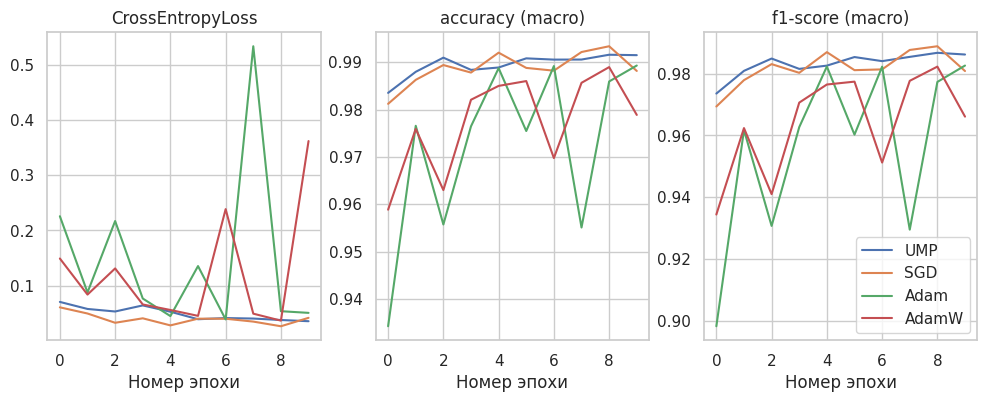

In [12]:
names = ["UMP", "SGD", "Adam", "AdamW"]
dicts = []
dicts.append(np.load("MyOptimizer1_MNIST.npy", allow_pickle=True))
dicts.append(np.load("SGD_MNIST.npy", allow_pickle=True))
dicts.append(np.load("Adam_MNIST.npy", allow_pickle=True))
dicts.append(np.load("AdamW_MNIST.npy", allow_pickle=True))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(names):
    ax1.plot(dicts[i].item()['loss']['val'], label=name)

for i, name in enumerate(names):
    ax2.plot(dicts[i].item()['acc']['val'], label=name)
    
for i, name in enumerate(names):
    ax3.plot(dicts[i].item()['f1']['val'], label=name)

ax1.set_title("CrossEntropyLoss")
ax1.set_xlabel("Номер эпохи")
ax2.set_title("accuracy (macro)")
ax2.set_xlabel("Номер эпохи")
ax3.set_title("f1-score (macro)")
ax3.set_xlabel("Номер эпохи")

plt.legend(loc="lower right")
plt.show()

Посмотрим на графики метрик модели на валидации на датасете CIFAR10 (запускать ячейку после обучения в нижних ячейках)

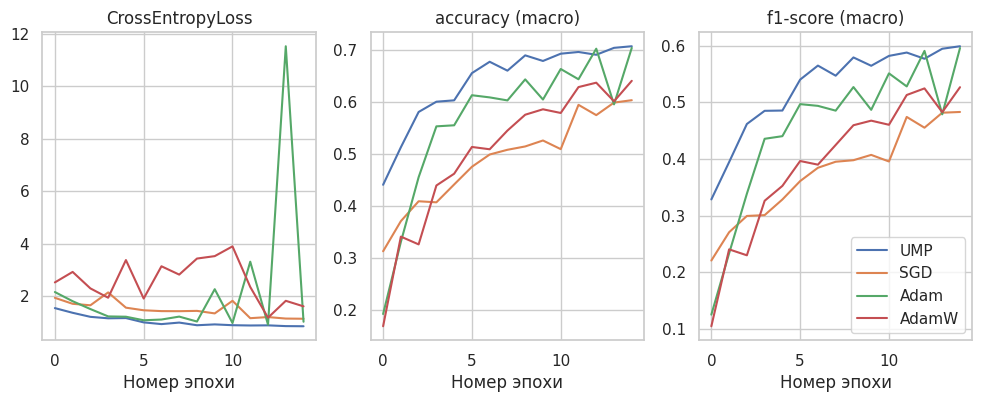

In [11]:
names = ["UMP", "SGD", "Adam", "AdamW"]
dicts = []
dicts.append(np.load("MyOptimizer1_CIFAR10.npy", allow_pickle=True))
dicts.append(np.load("SGD_CIFAR10.npy", allow_pickle=True))
dicts.append(np.load("Adam_CIFAR10.npy", allow_pickle=True))
dicts.append(np.load("AdamW_CIFAR10.npy", allow_pickle=True))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(names):
    ax1.plot(dicts[i].item()['loss']['val'], label=name)

for i, name in enumerate(names):
    ax2.plot(dicts[i].item()['acc']['val'], label=name)
    
for i, name in enumerate(names):
    ax3.plot(dicts[i].item()['f1']['val'], label=name)

ax1.set_title("CrossEntropyLoss")
ax1.set_xlabel("Номер эпохи")
ax2.set_title("accuracy (macro)")
ax2.set_xlabel("Номер эпохи")
ax3.set_title("f1-score (macro)")
ax3.set_xlabel("Номер эпохи")

plt.legend()
plt.show()

Функция для обучения моделей

In [9]:
def model_train(
    model,
    optimizer,
    criterion,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.
    Возвращает модель и словарь с метриками при обучении.
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        train_f1 = 0
        val_loss = 0
        val_acc = 0
        val_f1 = 0
            
        start_time = time.time()

        model.train(True) # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for data, target in tqdm(train_batch_gen, desc="training"):
            data = data.to(device)
            target = target.to(device)
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(data)
            loss = criterion(logits, target)
            # backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Cохраним лосс и посчитаем метрики
            train_loss += loss.item()
            y_pred = logits.argmax(axis=1).detach().cpu()
            train_acc += multiclass_accuracy(y_pred, target.cpu(),
                                             num_classes=CLASSES, average='macro')
            train_f1 += multiclass_f1_score(y_pred, target.cpu(),
                                            num_classes=CLASSES, average='macro')

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        train_f1 /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)
        history['f1']['train'].append(train_f1)

        model.train(False) # устанавливаем поведение dropout / batch_norm  в тестирование

        # Полный проход по валидации
        for data, target in tqdm(val_batch_gen, desc="evaluation"):
            data = data.to(device)
            target = target.to(device)
            # При использовании .no_grad() модель не будет считать и хранить градиенты.
            # Это ускорит процесс предсказания меток для валидационных данных.
            with torch.no_grad():
                logits = model(data)
                loss = criterion(logits, target)

            val_loss += loss.item()

            # применяем функцию max к каждому логиту из батча
            # функция max возвращает две величины: значения и индексы
            # выбираем индексы
            y_pred = logits.argmax(axis=1).detach().cpu()
            val_acc += multiclass_accuracy(y_pred, target.cpu(),
                                           num_classes=CLASSES, average='macro')
            val_f1 += multiclass_f1_score(y_pred, target.cpu(),
                                          num_classes=CLASSES, average='macro')

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        val_f1 /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)
        history['f1']['val'].append(val_f1)

        # Печатаем результаты после каждой эпохи
        clear_output(wait=False)
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        print("  training f1-score: \t\t\t{:.6f}".format(train_f1))
        print("  validation f1-score: \t\t\t{:.6f}".format(val_f1))

    # Рисуем график лоссов
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

    ax1.plot(history['loss']['train'], label='train')
    ax1.plot(history['loss']['val'], color="tab:orange",  label='valid')
    
    ax2.plot(history['acc']['train'], label='train')
    ax2.plot(history['acc']['val'], color="tab:orange",  label='valid')
    
    ax3.plot(history['f1']['train'], label='train')
    ax3.plot(history['f1']['val'], color="tab:orange",  label='valid')

    ax1.set_title("loss")
    ax1.set_xlabel("Номер эпохи")
    ax2.set_title("accuracy")
    ax2.set_xlabel("Номер эпохи")
    ax3.set_title("f1-score")
    ax3.set_xlabel("Номер эпохи")
    
    plt.legend()
    plt.show()
    
    return model, history

Последовательные обучения всех моделей

Epoch 10 of 10 took 214.854s
  training loss (in-iteration): 	0.051820
  validation loss (in-iteration): 	0.361875
  training accuracy: 			98.84 %
  validation accuracy: 			97.89 %
  training f1-score: 			0.979672
  validation f1-score: 			0.966107


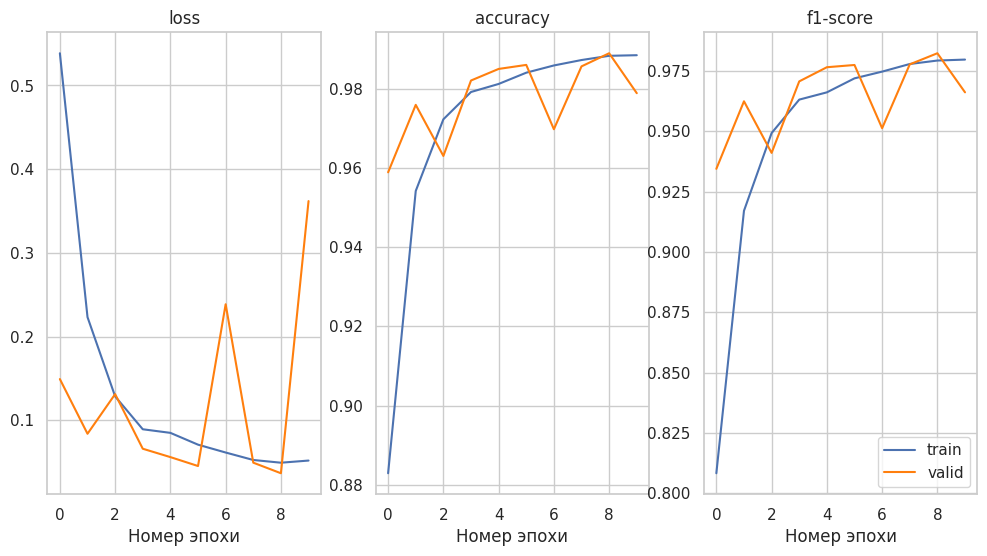

In [10]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_MNIST().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_MNIST, test_loader_MNIST,
    num_epochs=10
)
np.save('AdamW_MNIST', np.array(dict(history)))

Epoch 10 of 10 took 212.335s
  training loss (in-iteration): 	0.046018
  validation loss (in-iteration): 	0.050728
  training accuracy: 			98.93 %
  validation accuracy: 			98.93 %
  training f1-score: 			0.981152
  validation f1-score: 			0.982636


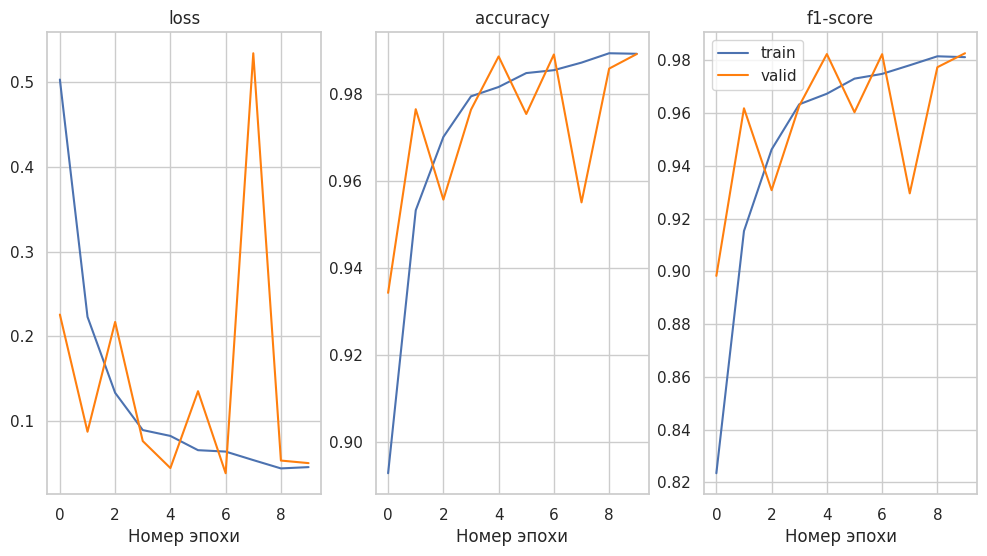

In [9]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_MNIST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_MNIST, test_loader_MNIST,
    num_epochs=10
)
np.save('Adam_MNIST', np.array(dict(history)))

Epoch 10 of 10 took 310.214s
  training loss (in-iteration): 	0.017383
  validation loss (in-iteration): 	0.035612
  training accuracy: 			99.53 %
  validation accuracy: 			99.15 %
  training f1-score: 			0.991850
  validation f1-score: 			0.986213


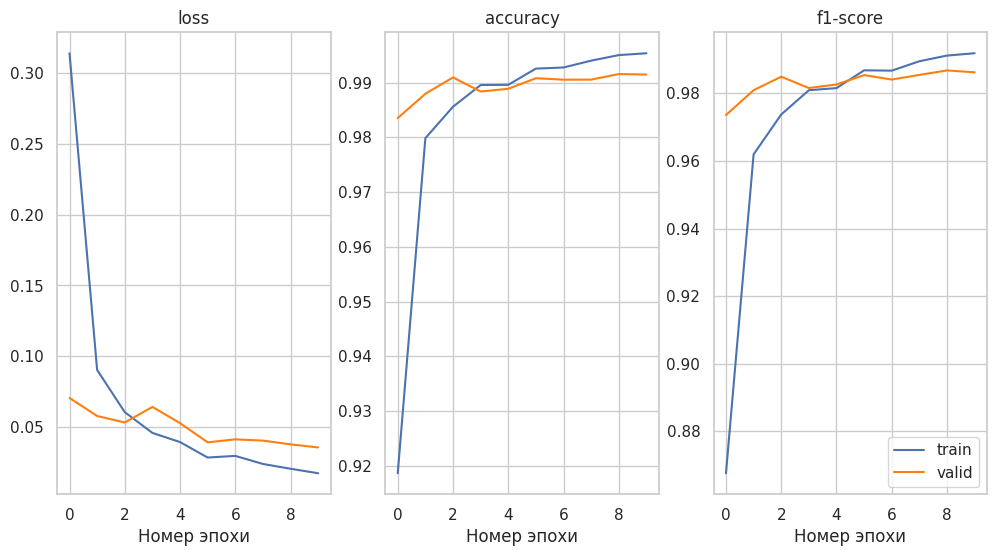

In [6]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_MNIST().to(device)
optimizer = MyOptimizer1(model.parameters(), lr=1e-2)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_MNIST, test_loader_MNIST,
    num_epochs=10
)
np.save('MyOptimizer1_MNIST', np.array(dict(history)))

Epoch 10 of 10 took 164.388s
  training loss (in-iteration): 	0.014747
  validation loss (in-iteration): 	0.041741
  training accuracy: 			99.56 %
  validation accuracy: 			98.81 %
  training f1-score: 			0.992224
  validation f1-score: 			0.980861


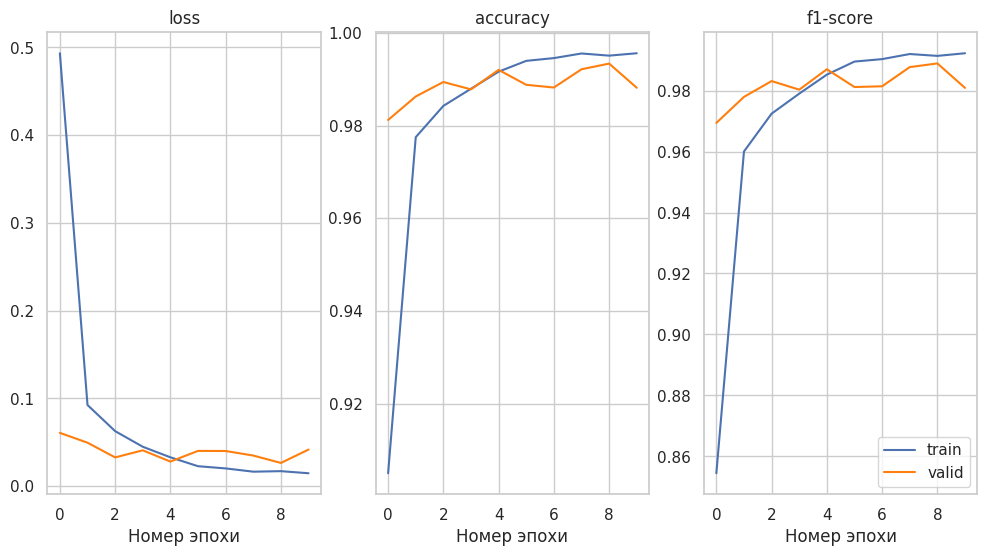

In [7]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_MNIST().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_MNIST, test_loader_MNIST,
    num_epochs=10
)
np.save('SGD_MNIST', np.array(dict(history)))

Epoch 15 of 15 took 175.869s
  training loss (in-iteration): 	0.876332
  validation loss (in-iteration): 	1.034491
  training accuracy: 			70.66 %
  validation accuracy: 			70.32 %
  training f1-score: 			0.587878
  validation f1-score: 			0.595963


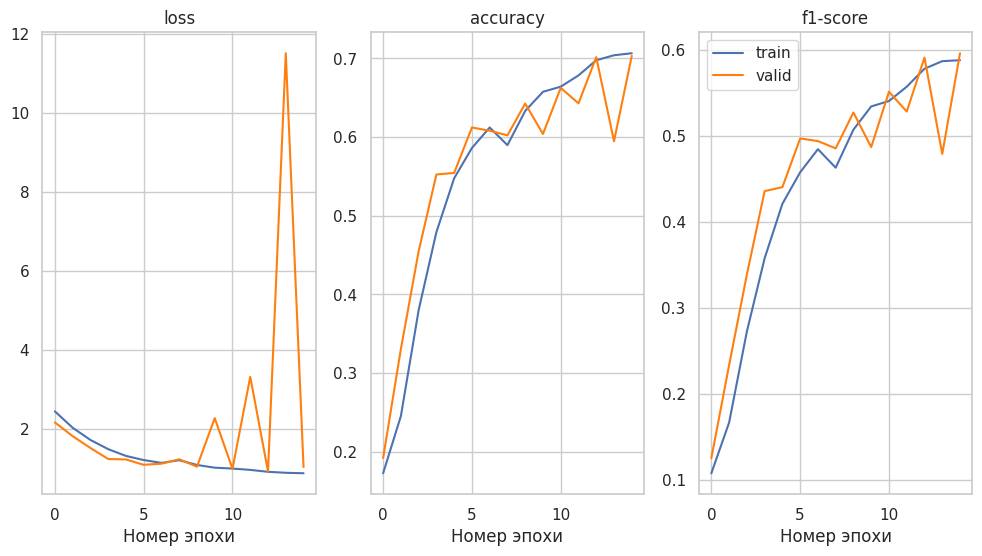

In [11]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_CIFAR10().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_CIFAR10, test_loader_CIFAR10,
    num_epochs=15
)
np.save('Adam_CIFAR10', np.array(dict(history)))

Epoch 15 of 15 took 184.901s
  training loss (in-iteration): 	0.969032
  validation loss (in-iteration): 	1.620239
  training accuracy: 			67.55 %
  validation accuracy: 			63.99 %
  training f1-score: 			0.551619
  validation f1-score: 			0.526814


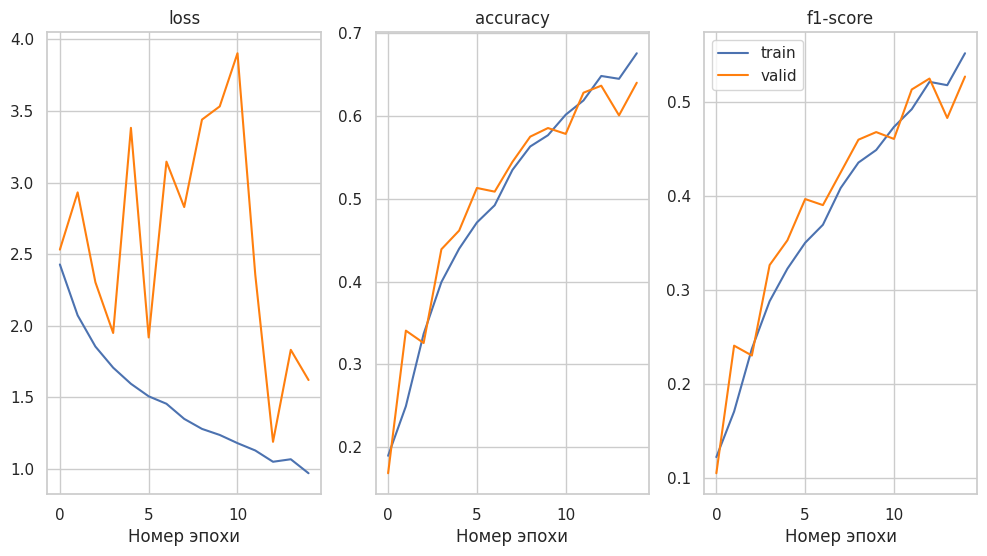

In [8]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_CIFAR10().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_CIFAR10, test_loader_CIFAR10,
    num_epochs=15
)
np.save('AdamW_CIFAR10', np.array(dict(history)))

Epoch 15 of 15 took 268.885s
  training loss (in-iteration): 	0.511646
  validation loss (in-iteration): 	0.862987
  training accuracy: 			83.82 %
  validation accuracy: 			70.63 %
  training f1-score: 			0.750553
  validation f1-score: 			0.599110


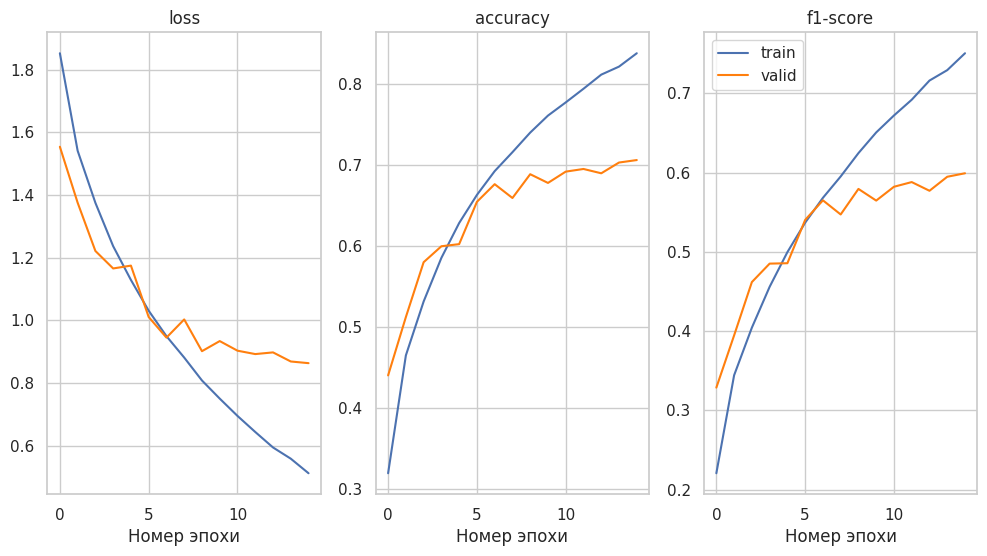

In [8]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_CIFAR10().to(device)
optimizer = MyOptimizer1(model.parameters(), lr=1e-2)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_CIFAR10, test_loader_CIFAR10,
    num_epochs=15
)
np.save('MyOptimizer1_CIFAR10', np.array(dict(history)))

Epoch 15 of 15 took 136.281s
  training loss (in-iteration): 	1.060105
  validation loss (in-iteration): 	1.148687
  training accuracy: 			63.85 %
  validation accuracy: 			60.27 %
  training f1-score: 			0.511964
  validation f1-score: 			0.483068


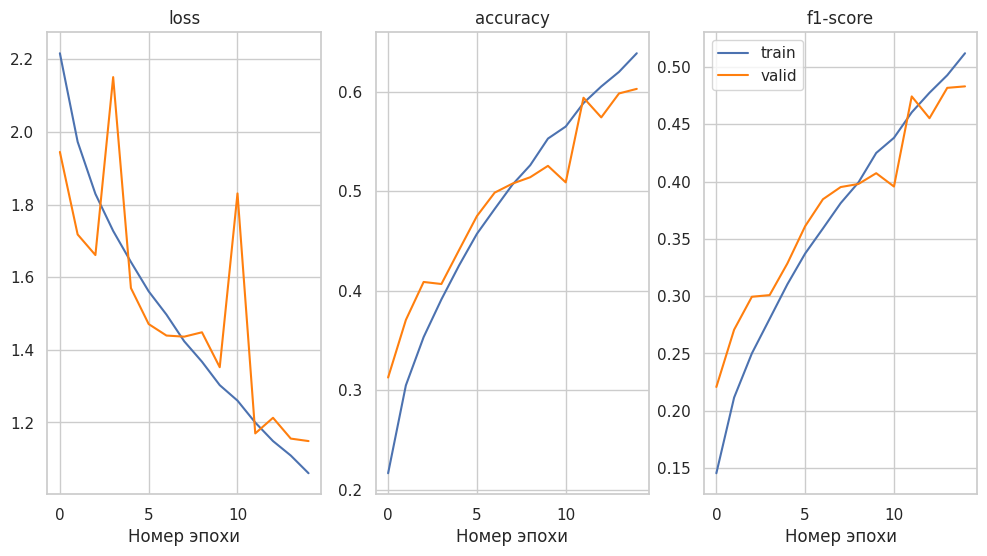

In [6]:
logging.getLogger().setLevel(logging.ERROR)

device = "cuda"
criterion = nn.CrossEntropyLoss()
model = Model_CIFAR10().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

model, history = model_train(
    model, optimizer, criterion,
    train_loader_CIFAR10, test_loader_CIFAR10,
    num_epochs=15
)
np.save('SGD_CIFAR10', np.array(dict(history)))